## Extracting the relationships among the characters

### Import Libraries
* spacy - this is required to handle text data
* networkx - this is required to create, manipulate, and study of the structure, dynamics, and functions of complex networks.
* pyvis - visualize networks with a more more interactive network

In [2]:
import pandas as pd
import numpy as np
import spacy as sp
import networkx as nx
from spacy import displacy
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
ner = sp.load('en_core_web_sm')

### Load the books

* Get all the books(.txt files)
* We will be using the first book to demonstrate the network analysis of the characters
* Next I have read the first book, and used the spacy lib to remove informities from the book's text

In [3]:
import os

all_books = [b for b in os.listdir('Books') if '.txt' in b]

In [4]:
all_books

["Book 1 - The Philosopher's Stone.txt",
 'Book 2 - The Chamber of Secrets.txt',
 'Book 3 - The Prisoner of Azkaban.txt',
 'Book 4 - The Goblet of Fire.txt',
 'Book 5 - The Order of the Phoenix.txt',
 'Book 6 - The Half Blood Prince.txt',
 'Book 7 - The Deathly Hallows.txt']

In [ ]:
book = all_books[0]
book_text = open(os.path.join('Books',book), encoding="utf8").read()
book_doc = ner(book_text)
book_doc

#### Visualize identified entities

In [ ]:
displacy.render(book_doc[:2000],style='ent',jupyter=True)

##### Read the characters dataset for future use

In [5]:
chars = pd.read_csv('characters.csv')

### Getting the entities of each sentence in the book

* We iterate through the entire book and append a dictionary containing the sentence and a list of its entities to an outer list
* Next we filter the entity list by removing entities that are not character names 

In [8]:
se_df = [] 
# loop through sentences , store named entity list for each sentence
for sent in book_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    se_df.append({'sentence':sent,'entities':entity_list})

se_df = pd.DataFrame(se_df)

In [9]:
se_df

,sentence,entities
0,"(/, \n\n\n\n\n, THE, BOY, WHO, LIVED, \n\n, Mr...","[Dursley, number four, Privet Drive]"
1,"(They, were, the, last, people, you, ’d, \n, e...",[]
2,"(Mr., Dursley, was, the, director, of, a, firm...","[Dursley, Grunnings]"
3,"(He, was, a, big, ,, beefy, \n, man, with, har...",[]
4,"(Mrs., Dursley, was, thin, and, \n, blonde, an...",[Dursley]
...,...,...
6976,"(Page, |, 347, Harry, Potter, and, the, Philos...",[Harry Potter]
6977,"(“, Oh, ,, I, will, ,, ”, said, Harry, ,, and,...",[Harry]
6978,"(“, They, do, n’t, \n, know, we, ’re, not, all...",[]
6979,"(I, ’m, \n, going, to, have, a, lot, of, fun, ...","[Dudley, this summer]"


In [10]:
def filter(char_df,ent_list):
    return [ent for ent in ent_list 
            if ent in list(char_df.CharacterName)]

In [11]:
se_df['char_entities'] = se_df['entities'].apply(lambda x:filter(chars,x))

In [12]:
se_df

,sentence,entities,char_entities
0,"(/, \n\n\n\n\n, THE, BOY, WHO, LIVED, \n\n, Mr...","[Dursley, number four, Privet Drive]",[]
1,"(They, were, the, last, people, you, ’d, \n, e...",[],[]
2,"(Mr., Dursley, was, the, director, of, a, firm...","[Dursley, Grunnings]",[]
3,"(He, was, a, big, ,, beefy, \n, man, with, har...",[],[]
4,"(Mrs., Dursley, was, thin, and, \n, blonde, an...",[Dursley],[]
...,...,...,...
6976,"(Page, |, 347, Harry, Potter, and, the, Philos...",[Harry Potter],[Harry Potter]
6977,"(“, Oh, ,, I, will, ,, ”, said, Harry, ,, and,...",[Harry],[]
6978,"(“, They, do, n’t, \n, know, we, ’re, not, all...",[],[]
6979,"(I, ’m, \n, going, to, have, a, lot, of, fun, ...","[Dudley, this summer]",[]


### Creating the relationship

* We take a window size, which basically means the number of sentences we take to consider a relationship among characters. 
* If 2 characters appear within the the range of the window size implies, they have a relation.
* For ex - window size = 5, this implies if 2 character names appear in the range of 5 sentences
* If you didn't understand the above explanation - Listen
* We add the entities' list for every 5(window size) sentences in the se_df(dataframe), therefore the entities within the added list(char_list) have relations with each other.
* Next we need to remove duplicates from the added list(char_list), because a character cannot have a relation with themselves.
* After that we create dictionaries for each element in the char_unique list, where they are the source and the characters ahead are their respective targets.
* We append each dictionary to an outer list
* Finally convert the list into a dataframe

In [13]:
window_size = 5
rels = []

for i in range(se_df.shape[0]):
    end = min(i+5,se_df.shape[0])
    char_list = sum((se_df.loc[i:end].char_entities),[])
    # Remove Duplicates in char_list
    char_unique = [char_list[i] for i in range(len(char_list))
                   if (i==0) or char_list[i]!=char_list[i-1]]
    # print(char_unique)
    if len(char_unique)>1:
        for idx,i in enumerate(char_unique[:-1]):
                b = char_unique[idx+1]
                rels.append({'source':i,'target':b})

In [14]:
rels_df = pd.DataFrame(rels)
rels_df

,source,target
0,Harry Potter,Albus Dumbledore
1,Harry Potter,Albus Dumbledore
2,Harry Potter,Albus Dumbledore
3,Minerva McGonagall,Harry Potter
4,Minerva McGonagall,Harry Potter
...,...,...
371,Harry Potter,Ginny Weasley
372,Ginny Weasley,Harry Potter
373,Harry Potter,Ginny Weasley
374,Ginny Weasley,Harry Potter


In [15]:
rels_df.to_csv('relations.csv',index=False)

### Organising the relations

* First we rearrange the source and target alphabetically
* ex - Source=Harry Potter Target=Hedwig ; Source=Hedwig Target=Harry Potter ; These two mean the same, thus we need to convert all such rows to a single form
* Therefore we sort the values column wise meaning in the above example,  Source=Hedwig Target=Harry Potter => Source=Harry Potter Target=Hedwig
* Next we add a new column to the sorted dataframe, giving it a default value of 1
* Next we add the weights by grouping similar rows, thus getting the weightage of each relationship.

In [16]:
rels_df = pd.read_csv('relations.csv')
j = pd.DataFrame(np.sort(rels_df.values,axis=1),columns=rels_df.columns)
j.to_csv('relations.csv',index=False)

In [17]:
rels_df = pd.read_csv('relations.csv')
rels_df['weights'] = 1

In [18]:
rels_df = rels_df.groupby(['source','target'],sort=False,as_index=False).sum()

In [19]:
rels_df.to_csv('relations_weights.csv',index=False)
rels_df

,source,target,weights
0,Albus Dumbledore,Harry Potter,16
1,Harry Potter,Minerva McGonagall,6
2,Harry Potter,James Potter,5
3,Cornelius Fudge,Harry Potter,2
4,Dedalus Diggle,Harry Potter,6
5,Griphook,Harry Potter,5
6,Harry Potter,Hedwig,17
7,Albus Dumbledore,Nicolas Flamel,3
8,Draco Malfoy,Goyle,4
9,Draco Malfoy,Harry Potter,25


In [4]:
rels_df = pd.read_csv('relations_weights.csv')

### Creating the Graph

* We use the networkx lib, and the give the relations dataframe, with the column names for the respective arguments, and create the graph
* We need to import scipy to run this part
* We chose a network positions layout, and draw the network structure of the relations among the characters, where each node represents a character and the line joining the nodes their relationship.
* But this is not an interactive network graph, rather a static image.

In [5]:
# create a graph from pandas df
g = nx.from_pandas_edgelist(rels_df,source='source',target='target',edge_attr='weights',
                            create_using=nx.Graph())

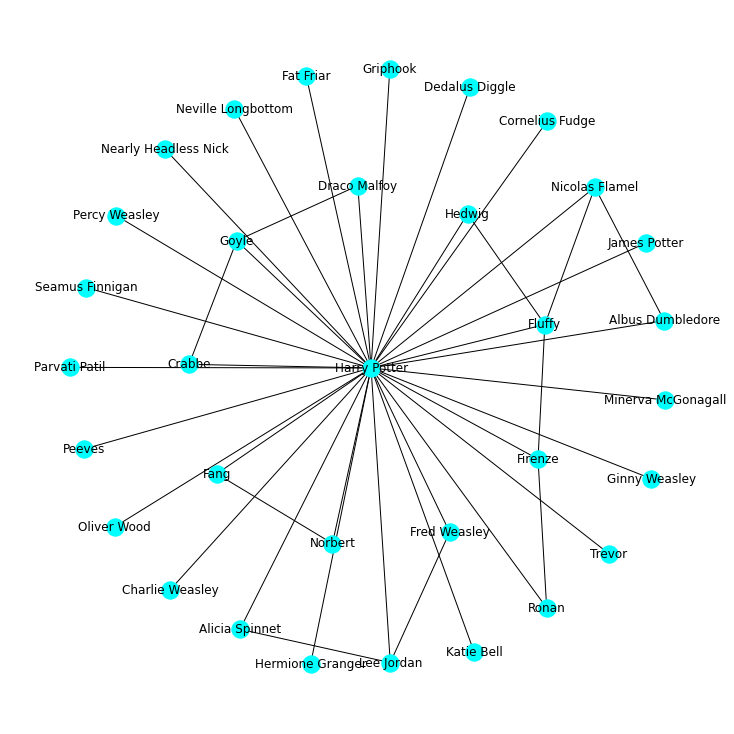

In [6]:
import scipy as sc

pos = nx.kamada_kawai_layout(g)
plt.figure(figsize=(10,10))
nx.draw(g,with_labels=True,node_color='cyan',edge_cmap=plt.cm.Blues,pos=pos)
plt.show()

### Interactive Network Analysis

* Here we use the network module of the pyvis lib
* Initialize a Network variable with the appropriate arguments
* Customizing the node size based on the degree(node size increases with more relations, the degree is the angle between each relation)

In [7]:
from pyvis.network import Network

net= Network(notebook=True,width='1000px',height='1000px',
             bgcolor='#222222',font_color='white')

# customize node size
node_degree = dict(g.degree)
nx.set_node_attributes(g,node_degree,'size')

net.from_nx(g)
net.show('harrypotter.html')

### Calculating centrality parameters of the network graph

* Degree Centrality, and their respective plots
* Closeness Centrality, and their respective plots
* Betweenness Centrality, and their respective plots

In [8]:
# Degree Centrality
degree_dict = nx.degree_centrality(g)
degree_dict

{'Albus Dumbledore': 0.0625,
 'Harry Potter': 1.0,
 'Minerva McGonagall': 0.03125,
 'James Potter': 0.03125,
 'Cornelius Fudge': 0.03125,
 'Dedalus Diggle': 0.03125,
 'Griphook': 0.03125,
 'Hedwig': 0.0625,
 'Nicolas Flamel': 0.09375,
 'Draco Malfoy': 0.0625,
 'Goyle': 0.09375,
 'Fat Friar': 0.03125,
 'Neville Longbottom': 0.03125,
 'Nearly Headless Nick': 0.03125,
 'Percy Weasley': 0.03125,
 'Fang': 0.0625,
 'Seamus Finnigan': 0.03125,
 'Parvati Patil': 0.03125,
 'Peeves': 0.03125,
 'Oliver Wood': 0.03125,
 'Charlie Weasley': 0.03125,
 'Hermione Granger': 0.03125,
 'Alicia Spinnet': 0.0625,
 'Lee Jordan': 0.09375,
 'Katie Bell': 0.03125,
 'Fred Weasley': 0.0625,
 'Fluffy': 0.125,
 'Crabbe': 0.0625,
 'Norbert': 0.0625,
 'Ronan': 0.0625,
 'Firenze': 0.09375,
 'Trevor': 0.03125,
 'Ginny Weasley': 0.03125}

<AxesSubplot:>

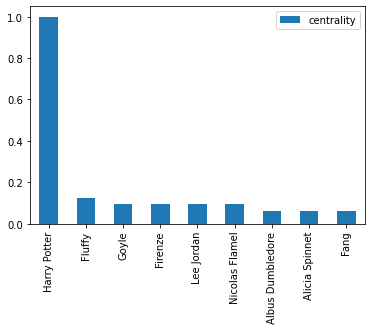

In [9]:
degree_df = pd.DataFrame.from_dict(degree_dict,
                    orient='index',columns=['centrality'])

#Plot top 10 nodes
degree_df.sort_values('centrality',ascending=False)[:9].plot(kind='bar')

<AxesSubplot:>

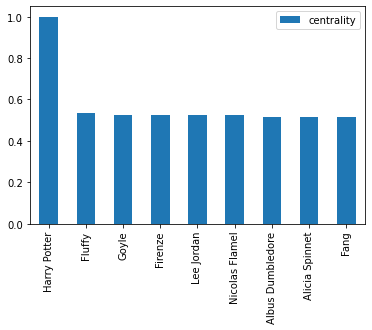

In [10]:
# Closeness Centrality
close_dict = nx.closeness_centrality(g)
close_dict
close_df = pd.DataFrame.from_dict(close_dict,
                    orient='index',columns=['centrality'])

#Plot top 10 nodes
close_df.sort_values('centrality',ascending=False)[:9].plot(kind='bar')

<AxesSubplot:>

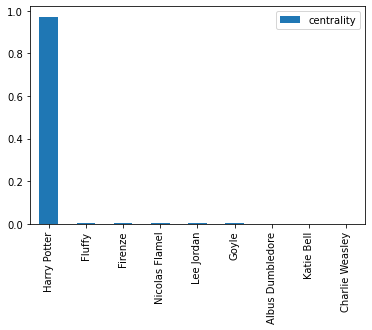

In [11]:
# Betweenness Centrality
betweenness_dict = nx.betweenness_centrality(g)
betweenness_dict
betweenness_df = pd.DataFrame.from_dict(betweenness_dict,
                    orient='index',columns=['centrality'])

#Plot top 10 nodes
betweenness_df.sort_values('centrality',ascending=False)[:9].plot(kind='bar')

In [12]:
# Save centrality measures
nx.set_node_attributes(g,degree_dict,'degree_centrality')
nx.set_node_attributes(g,close_dict,'closeness_centrality')
nx.set_node_attributes(g,betweenness_dict,'betweenness_centrality')

### Creating communities from relations network(by assigning different colors to each community)
###### import community as community_louvain


In [13]:
import community as community_louvain

* create communities by partitioning the graph

In [14]:
communities = community_louvain.best_partition(g)

In [15]:
nx.set_node_attributes(g,communities,'group')

In [16]:
com_net = Network(notebook=True,width='1000px',height='700px',
                  bgcolor='#222222',font_color='white')

com_net.from_nx(g)
com_net.show('harrypotter_communites.html')

### Lastly we check the timeline of the character relevance/adaptability throughout the series of books

* Perform all the steps from the reading each book to prepare graphs for each book's sentences' entities' relations
* Then calculate the degree centrality of each graph
* Finally plot the graph of the characters you wish to visualize their character development through all the books

In [41]:
# Initialize empty list for graphs from books
books_graph = []
all_books = [b for b in os.listdir('Books') if '.txt' in b]

all_books.sort(key=lambda x:x)

In [42]:
all_books

["Book 1 - The Philosopher's Stone.txt",
 'Book 2 - The Chamber of Secrets.txt',
 'Book 3 - The Prisoner of Azkaban.txt',
 'Book 4 - The Goblet of Fire.txt',
 'Book 5 - The Order of the Phoenix.txt',
 'Book 6 - The Half Blood Prince.txt',
 'Book 7 - The Deathly Hallows.txt']

In [43]:
from functions import *

In [11]:
# Loop through all the books to retrieve the graphs
for book in all_books:
    book_doc = book_text(book)
    se_df = get_entities(book_doc)
    se_df['char_entities'] = se_df['entities'].apply(lambda x:filter_entities(chars,x))
    rels_df = create_relations(se_df,5)
    rels_df = organise_entity_df(rels_df)
    g = nx.from_pandas_edgelist(rels_df,source='source',target='target',edge_attr='weights',
                            create_using=nx.Graph())
    books_graph.append(g)

In [16]:
import pickle

with open('books_graphs.pkl','wb') as f:
    pickle.dump(books_graph, f)

In [44]:
import pickle

with open('books_graphs.pkl','rb') as f:
    books_graph = pickle.load(f)

In [45]:
evol = [nx.degree_centrality(g) for g in books_graph]

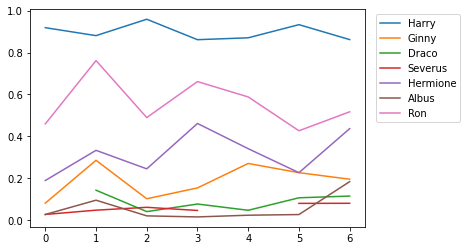

In [46]:
degree_evol_df = pd.DataFrame.from_records(evol)
degree_evol_df[['Harry','Ginny','Draco','Severus','Hermione','Albus','Ron']].plot()
plt.legend(loc='upper right',bbox_to_anchor=(1.3,1))



## I would like to thank Thu Vu Ma'am for introducing this concept of network analysis